# 1 Import Packages

In [4]:
import xarray as xr
import numpy as np
import os
import datetime


import src.config as config
import src.utils as utils

import math
from tqdm import tqdm

import innvestigate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


# 2 Metadata

In [5]:
lev_index   = 0
kfold_index = 0
exp_name    = "cv"
datetime_string = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")


In [ ]:
# Parameters
lev_index = "23"
kfold_index = "0"
datetime_string = "20_02_2023_16_16_46"


In [6]:
model_name = "conv_level_{}_experiment_{}".format(lev_index, datetime_string)
model_path = os.path.join(config.model_path,exp_name, model_name)
os.makedirs(model_path, exist_ok=True)

In [9]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", exp_name)

In [10]:
train_x_filename = "train_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, exp_index)
valid_x_filename = "valid_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, exp_index)

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, exp_index)
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, exp_index)

# 3 Load Data

In [12]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename))
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename))

In [13]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [14]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path, train_y_filename ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path, valid_y_filename))

# 4 Processing

In [15]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time"))

In [16]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


In [17]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

train_x_ml_np = np.nan_to_num(np.expand_dims(train_x_xr_stack["rho"].transpose("sample",...).values,3),0)
valid_x_ml_np = np.nan_to_num(np.expand_dims(valid_x_xr_stack["rho"].transpose("sample",...).values,3),0)

train_y_ml_np = train_y_xr_stack["atlantic_moc"].values
valid_y_ml_np = valid_y_xr_stack["atlantic_moc"].values

In [20]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

In [21]:
lon = train_x_xr_stack.lon
lat = train_x_xr_stack.lat

# 5 Model

In [22]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(30,(3,3), activation="relu", padding="same",input_shape=(120,121,1)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(30,(3,3), activation="relu", padding="same", input_shape=(60,60,8)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(30,(3,3), activation="relu", padding="same", input_shape=(30,30,32)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())

#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(50, activation="relu"))
#model.add(tf.keras.layers.BatchNormalization())

#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(50, activation="relu"))
#model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation="linear"))

In [23]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 121, 30)      300       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 30)        8130      
                                                                 
 flatten (Flatten)           (None, 27000)             0

In [28]:
model_file_template = os.path.join(model_path, "saved-model-{epoch:02d}.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_template, monitor='val_mse', verbose=1, save_best_only=False, mode='max')

In [29]:
from tensorflow.keras.callbacks import Callback

class TrainValMSEDiff(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        train_mse = model.evaluate(train_x_ml_np, train_y_ml_np)
        valid_mse = model.evaluate(valid_x_ml_np, valid_y_ml_np)
        diff_mse  = train_mse - valid_mse
        
        logs["train_mse_epoch_end"] = train_mse
        logs["valid_mse_epoch_end"] = valid_mse
        logs["diff_mse_epoch_end"] = diff_mse
        print(f'Epoch {epoch+1} - train_mse: {train_mse:.4f} - val_mse: {valid_mse:.4f} - diff: {diff_mse:.4f}')


In [2]:
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(model_path, "history.csv"))

NameError: name 'tf' is not defined

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(model_path,"logs"))

# Train Model

In [32]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss=tf.keras.losses.mse)

In [ ]:
model.fit(x=train_x_ml_np, y=train_y_ml_np, batch_size=64, epochs=200, validation_data=(valid_x_ml_np, valid_y_ml_np), callbacks = [TrainValMSEDiff(), checkpoint, csv_logger, tensorboard_callback])


Train on 13600 samples, validate on 2000 samples
Epoch 1/200


2023-02-19 16:24:33.483948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 16:24:33.727587: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-19 16:24:33.756213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


   64/13600 [..............................] - ETA: 13:26 - loss: 0.9571

2023-02-19 16:24:37.311459: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-19 16:24:37.311494: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  128/13600 [..............................] - ETA: 9:44 - loss: 0.8245 

2023-02-19 16:24:38.799224: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-19 16:24:38.801131: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-19 16:24:38.893460: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /work/uo1075/u301101/Doktorarbeit/CNN/models/cv/conv_level_0_experiment_1/logs/plugins/profile/2023_02_19_16_24_38

2023-02-19 16:24:38.900338: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /work/uo1075/u301101/Doktorarbeit/CNN/models/cv/conv_level_0_experiment_1/logs/plugins/profile/2023_02_19_16_24_38/l30406.lvt.dkrz.de.trace.json.gz
2023-02-19 16:24:38.938034: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /work/uo1075/u301101/Doktorarbeit/CNN/models/cv/conv_level_0_experiment_1/logs/plugins/profile/2023_02_19_16_24_38

2023-02-19 16:24:38.945028: I tensorflow/cor

13600/13600 [==============================] - ETA: 0s - loss: 0.8646

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 1 - train_mse: 0.6473 - val_mse: 0.6633 - diff: -0.0160

Epoch 1: saving model to /work/uo1075/u301101/Doktorarbeit/CNN/models/cv/conv_level_0_experiment_1/saved-model-01.hdf5
13600/13600 [==============================] - 260s 19ms/sample - loss: 0.8646 - val_loss: 0.6633 - train_mse_epoch_end: 0.6473 - valid_mse_epoch_end: 0.6633 - diff_mse_epoch_end: -0.0160
Epoch 2/200
13600/13600 [==============================] - ETA: 0s - loss: 0.5969Epoch 2 - train_mse: 0.5460 - val_mse: 0.5585 - diff: -0.0125

Epoch 2: saving model to /work/uo1075/u301101/Doktorarbeit/CNN/models/cv/conv_level_0_experiment_1/saved-model-02.hdf5
13600/13600 [==============================] - 147s 11ms/sample - loss: 0.5969 - val_loss: 0.5585 - train_mse_epoch_end: 0.5460 - valid_mse_epoch_end: 0.5585 - diff_mse_epoch_end: -0.0125
Epoch 3/200
13600/13600 [==============================] - ETA: 0s - loss: 0.5333Epoch 3 - train_mse: 0.5044 - val_mse: 0.5288 - diff: -0.0244

Epoch 3: saving model to /work/uo10

In [ ]:
model.load_weights(os.path.join(model_path, "saved-model-100.hdf5"))

# Evaluation

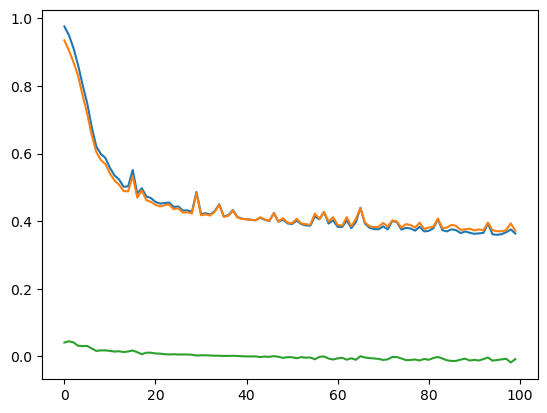

In [ ]:
plt.plot(model.history.history["train_mse_epoch_end"])
plt.plot(model.history.history["valid_mse_epoch_end"])
plt.plot(model.history.history["diff_mse_epoch_end"])

## Weights 

In [131]:
weights_first_conv = model.layers[0].get_weights()[0]

In [132]:
n_conv = weights_first_conv.shape[3]

In [133]:
n_cols = math.floor(np.sqrt(n_conv))
n_rows = math.ceil(np.sqrt(n_conv))

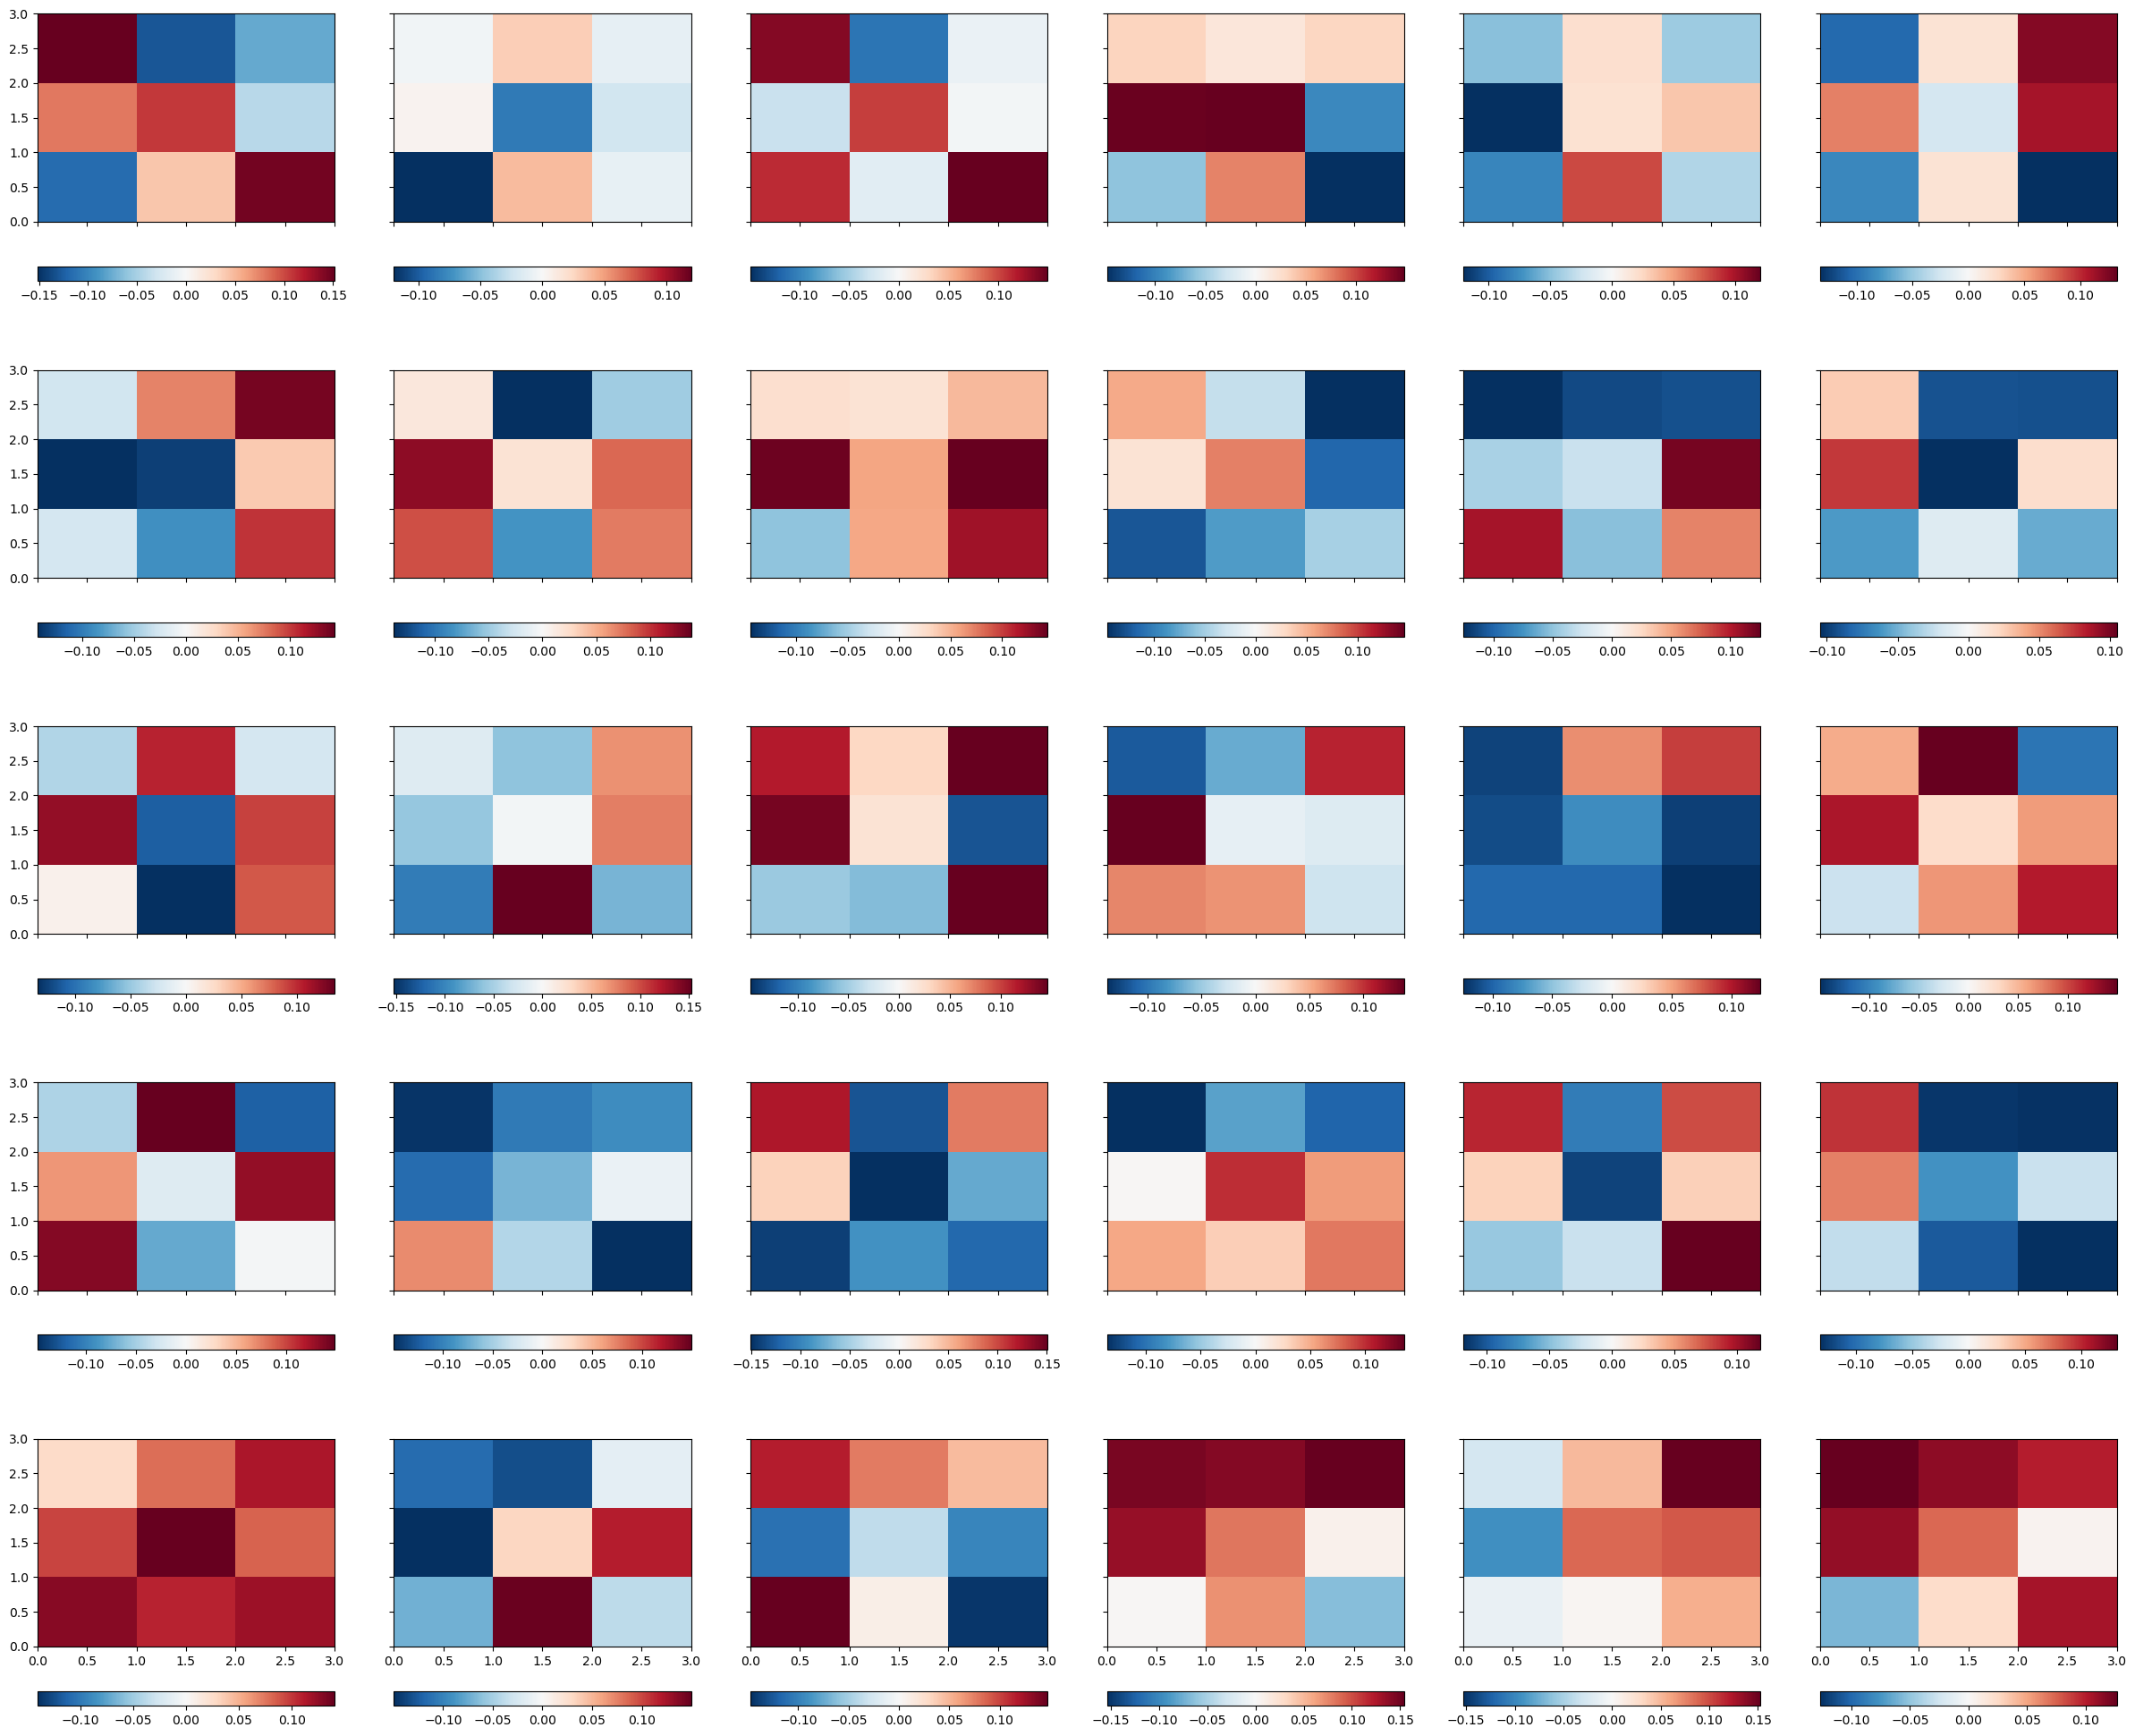

In [134]:
fig, ax = plt.subplots(n_cols, n_rows, sharex=True, sharey=True, figsize=(n_rows*5, n_cols*5))

ax_ravel = np.ravel(ax)
for i, ax in enumerate(ax_ravel):
    tmp = weights_first_conv[:,:,0,i]
    vmax = np.abs(tmp).max()
    plot = ax.pcolormesh(tmp, vmin = -vmax, vmax= vmax, cmap="RdBu_r")
    plt.colorbar(plot, ax = ax, orientation="horizontal")

In [135]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,outputs=model.layers[0].output)

In [136]:
int_media_layer_pred = intermediate_layer_model.predict(train_x_ml_np)

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [139]:
n_hidden_layers = int_media_layer_pred.shape[-1]

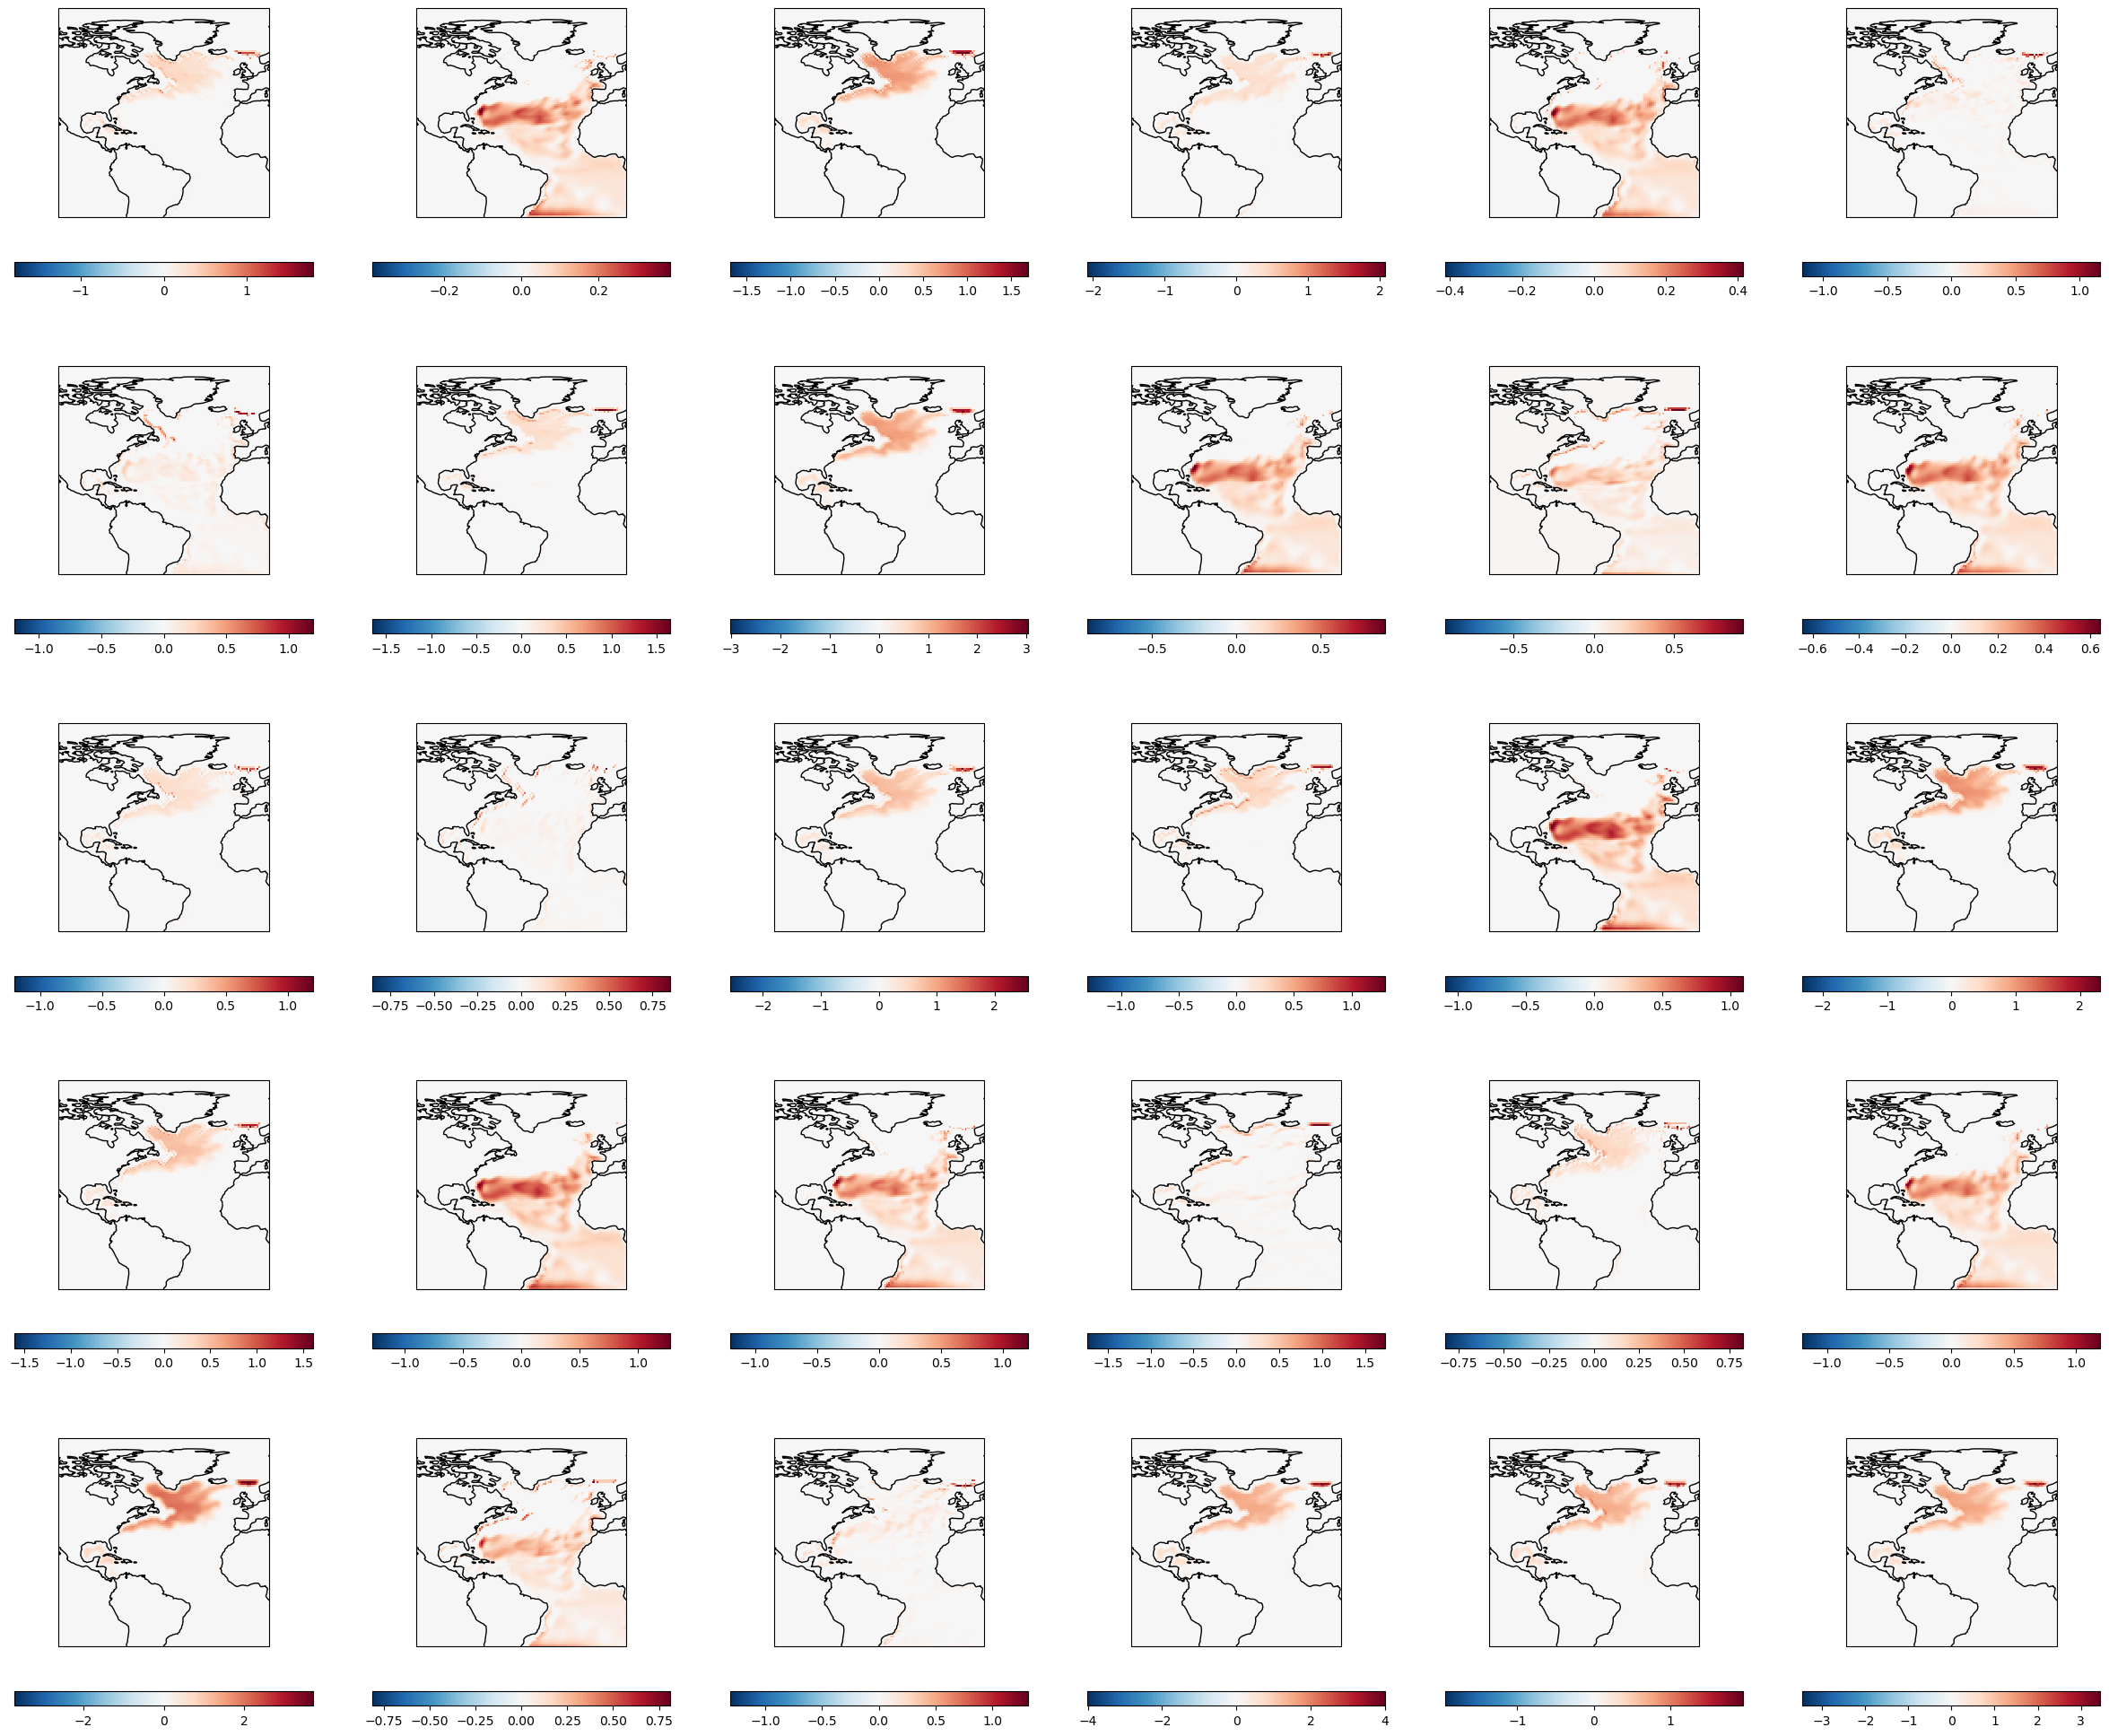

In [140]:
fig, ax = plt.subplots(n_cols, n_rows, sharex=True, sharey=True, figsize=(n_rows*5, n_cols*5), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)
for i, ax in enumerate(ax_ravel):
    tmp = int_media_layer_pred[1,:,:,i]
    vmax = np.abs(tmp).max()
    plot = ax.pcolormesh(lon, lat, tmp, vmin = -vmax, vmax= vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
    ax.coastlines()
    plt.colorbar(plot, ax = ax, orientation="horizontal")

In [141]:
y_train_pred = model.predict(train_x_ml_np)
y_train_true = train_y_ml_np

y_valid_pred = model.predict(valid_x_ml_np)
y_valid_true = valid_y_ml_np

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(0.0, 100.0)

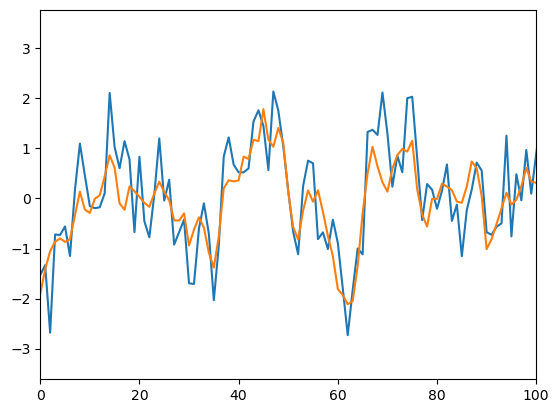

In [142]:
plt.plot(y_valid_true)
plt.plot(y_valid_pred)

plt.xlim(0,100)

(0.0, 100.0)

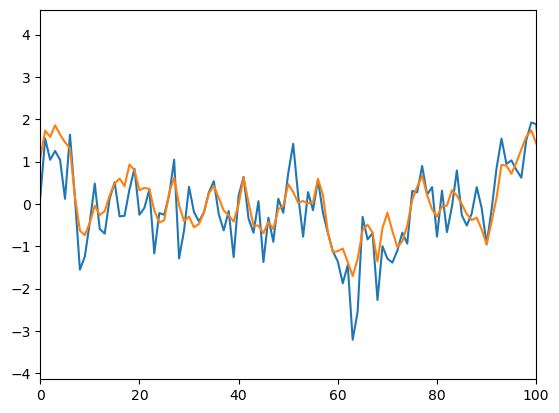

In [143]:
plt.plot(y_train_true)
plt.plot(y_train_pred)

plt.xlim(0,100)

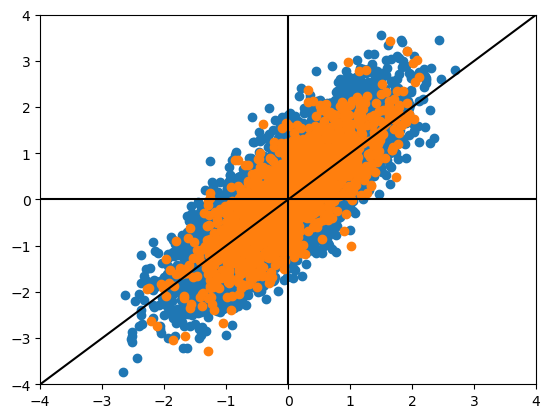

In [144]:
plt.scatter(y_train_pred, y_train_true)
plt.scatter(y_valid_pred, y_valid_true)

x = np.arange(-4,4+1)

plt.plot(x,x, color="black")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.axhline(0, color="black")
plt.axvline(0, color="black")

In [145]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model)

In [146]:
heatmaps = analyzer.analyze(train_x_ml_np[:,:,:,:])
heatmaps_xr = xr.DataArray(np.squeeze(heatmaps), name="heatmap", dims = ["sample", "lat","lon"], coords = {"sample":train_sample_coords, "lon":lon,"lat":lat})

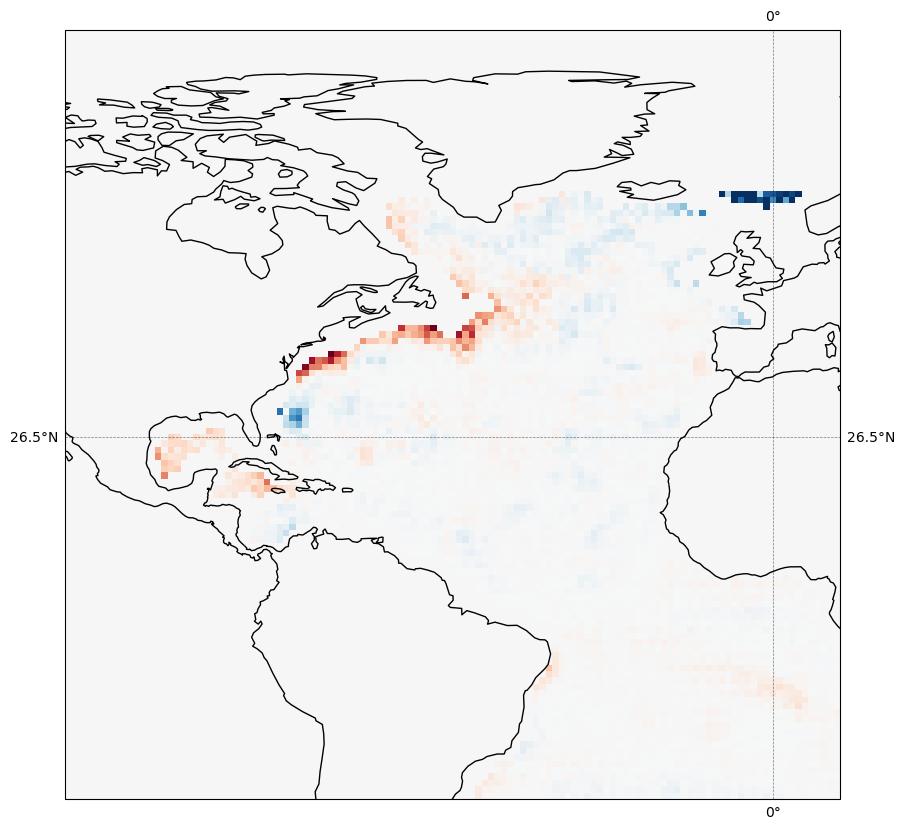

In [147]:
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})

tmp = heatmaps_xr.isel(sample=10)
vmax = np.abs(tmp).quantile(0.999)


ax.pcolormesh(lon, lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, transform=ccrs.PlateCarree(),cmap="RdBu_r")
ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

ax.coastlines()

